In [2]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import sys
import os
sys.path.append(os.path.abspath('..'))
from data.preprocessing import Preprocessor
from data.feature_generation import spec_preporarion, zpp4_preporarion, zpp4_features, spec_features, embed_features
from figures.plots import show_embeddings

pd.set_option('display.max_columns', None)

# import warnings
# warnings.filterwarnings('ignore')

In [3]:
"""
Загрузка данных
"""

# таблица со спецификациями
spec = pd.read_csv('../data/processed_data/specs.csv')
spec['spec_date'] = pd.to_datetime(spec['spec_date'], format='%Y-%m-%d')
spec['delivery_period_end'] = pd.to_datetime(spec['delivery_period_end'], format='%Y-%m-%d')

# таблица с доставками
zpp4 = pd.read_csv('../data/processed_data/zpp4.csv')
zpp4['date'] = pd.to_datetime(zpp4['date'], format='%Y-%m-%d')
zpp4['spec_date'] = pd.to_datetime(zpp4['spec_date'], format='%Y-%m-%d')

In [4]:
"""
Генерация фичей
"""

# Генерация фичей

spec = spec_preporarion(spec, zpp4)
zpp4 = zpp4_preporarion(zpp4, spec)

# фичи аггрегации параметров прошлых поставок
spec = zpp4_features(spec, zpp4)

# фичи эмбеддинги
spec = embed_features(spec)

# агрегация из прошлых спецификаций
spec = spec_features(spec, zpp4)

# кумулятивные фичи поставок
zpp4 = zpp4_preporarion(zpp4, spec)

# фичи
features = [['supplier_lateness', 'supplier_underweight', 'supplier_price_change'],
            [str(i) for i in range(16)],
            ['delivery_length', 'mean_delivery_length', 'delivery_length_diff',
             'mean_volume', 'volume_diff', 'conversion']]

C:\Users\vanya\Documents\Programs\ITMO_Sber\data\feature_generation.py:88: RuntimeWarning: divide by zero encountered in scalar divide
  lambda row: int((deliveries['quantity'].sum() / row['volume_contracted']) < 1) if len(


In [5]:
spec.head(2)

,supplier,supplier_status,spec_date,delivery_period_end,option,declared_price,consent_price,spec_price,volume_requested,volume_contracted,bids_submitted,bids_contracted,id,delivery_length,is_late,is_underweight,is_poorquality,supplier_lateness,supplier_underweight,supplier_price_change,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,mean_delivery_length,delivery_length_diff,mean_volume,volume_diff,conversion
0,50 ЛЕТ ОКТЯБРЯ ООО,1.0,2022-12-19,2022-12-25,15.0,25.5,25.0,25.0,40.0,60.0,1.0,1.0,"50 ЛЕТ ОКТЯБРЯ ООО_Юг Руси, АО_2022-12-19",6,0.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,50 ЛЕТ ОКТЯБРЯ ООО,1.0,2023-01-24,2023-02-12,15.0,27.5,27.5,27.5,50.0,59.0,1.0,1.0,"50 ЛЕТ ОКТЯБРЯ ООО_Юг Руси, АО_2023-01-24",19,0.0,0.0,0.0,0.333333,0.000833,-5.3406,0.221801,0.473711,-0.140701,-0.667289,0.461481,-0.282956,0.510517,0.245941,-0.13836,-0.16784,0.107102,-0.216089,-0.284308,-0.345988,-0.072292,-0.333858,6.0,13.0,40.0,10.0,1.0


In [6]:
zpp4.head(2)

,date,supplier,basis,spec_date,contract_price,estimated_price,contract_price1,estimated_price1,quantity,sum,price_change,id,delivery_period_end,volume_contracted,lateness_percentage,weight_percentage,relative_price_change,last_date,delivery_period_end_DROP,volume_contracted_DROP
0,2022-07-06,Рязанова А.В. ИП Глава К(Ф)Х,"ЮР Валуйский МЭЗ ф-л, ООО",2022-07-06,25.0,24.78,25.0,24.78,27.44,679963.2,-0.88,Рязанова А.В. ИП Глава К(Ф)Х_ЮР Валуйский МЭЗ ...,2022-07-09,30.0,0.0,0.914667,-0.804907,2022-07-06,2022-07-09,30.0
1,2022-07-12,Осипов Л.А. ИП Глава К(Ф)Х,"Юг Руси, АО",2022-07-12,25.0,24.68,25.0,24.55,31.43,771606.5,-1.80,"Осипов Л.А. ИП Глава К(Ф)Х_Юг Руси, АО_2022-07-12",2022-07-22,170.0,0.0,0.184882,-0.332788,2022-07-20,2022-07-22,170.0


In [6]:
# количество поставок по спецификации
spec['n_deliveries'] = spec.apply(lambda row: len(zpp4.loc[zpp4['id'] == row['id']]), axis=1)

In [7]:
# поставки по спецификации есть, хотя он не была законтрактована
len(spec.loc[(spec['n_deliveries'] > 0) & (spec['bids_contracted'] == 0)])

2

In [8]:
# поставок нет, хотя спецификация законтрактована
len(spec.loc[(spec['n_deliveries'] == 0) & (spec['bids_contracted'] == 1)])

862

## Анализ таблицы ЦК

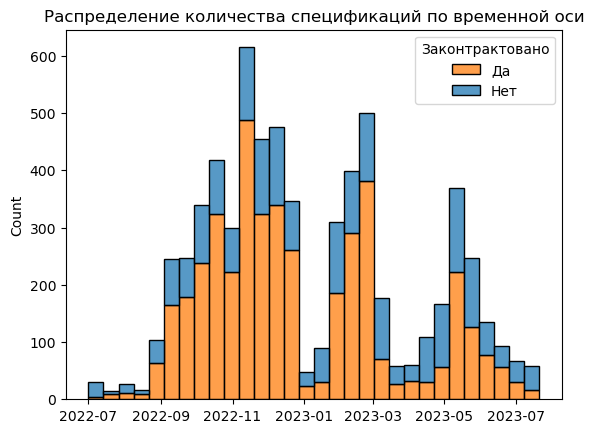

In [66]:
sns.histplot(data=spec, x='spec_date', hue='bids_contracted', multiple='stack').set(
    title='Распределение количества спецификаций по временной оси', xlabel='')
plt.legend(title='Законтрактовано', labels=['Да', 'Нет'])
plt.savefig('../figures/contracted_dist.jpg', bbox_inches='tight')

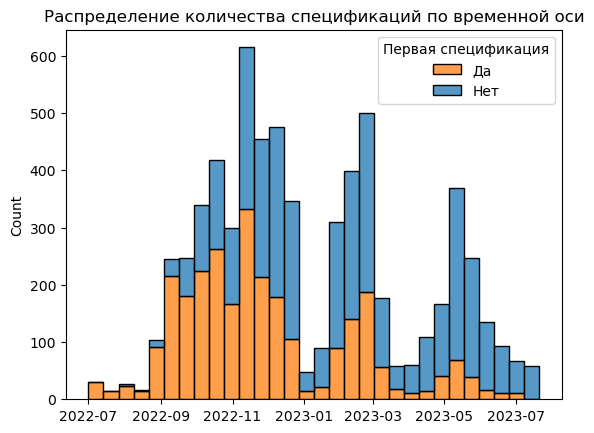

In [67]:
sns.histplot(x=spec['spec_date'], hue=spec['0'].isna(), multiple='stack').set(
    title='Распределение количества спецификаций по временной оси', xlabel='')
plt.legend(title='Первая спецификация', labels=['Да', 'Нет'])
plt.savefig('../figures/first_contract_dist.jpg', bbox_inches='tight')

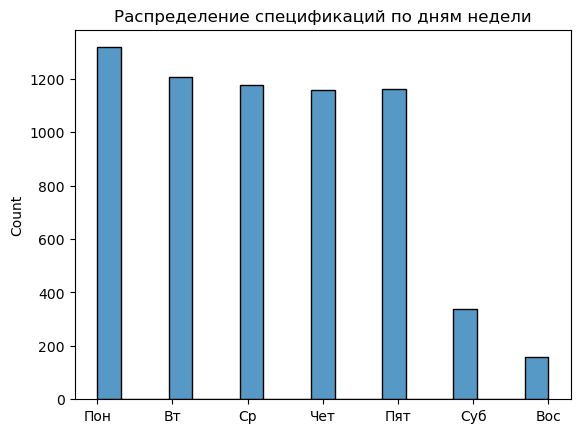

In [7]:
weekdays = ['Пон', 'Вт', 'Ср', 'Чет', 'Пят', 'Суб', 'Вос']
sns.histplot(spec['spec_date'].map(lambda x: x.weekday())).set(
    title='Распределение спецификаций по дням недели',
    xlabel='')
plt.xticks(range(7), weekdays)
plt.savefig('../figures/weekday_dist.jpg', bbox_inches='tight')

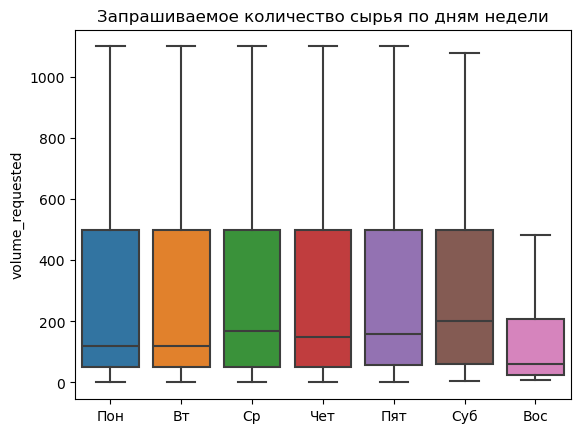

In [8]:
sns.boxplot(x=spec['spec_date'].map(lambda x: x.weekday()), y = spec['volume_requested'], showfliers=False).set(
    title='Запрашиваемое количество сырья по дням недели',
    xlabel='')
plt.xticks(range(7), weekdays)
plt.savefig('../figures/weekday_volume_dist.jpg', bbox_inches='tight')

## Анализ таблицы ZPP4

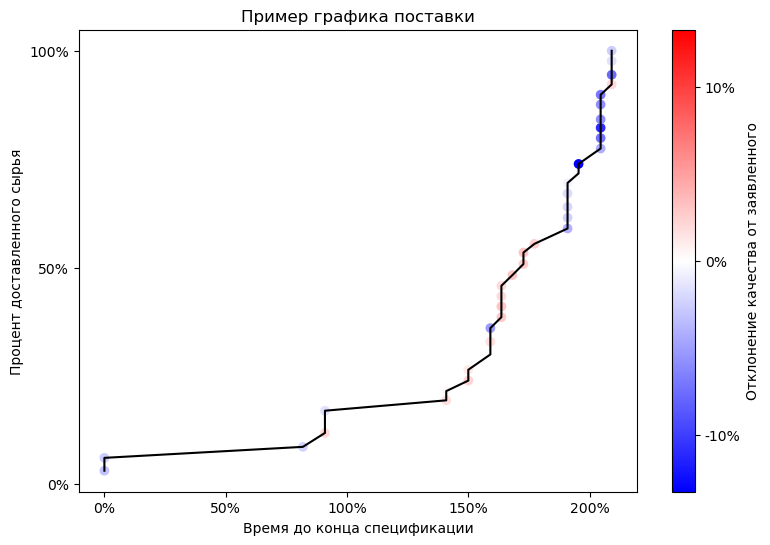

In [26]:
# выбираем историю поставок
history = zpp4[zpp4['id'] == zpp4['id'].unique()[133]]
x = history['lateness_percentage'].values
y = history['weight_percentage'].values
annotation = history['price_change'].values

# настройки графика
plt.figure(figsize=(9, 6))
plt.xlabel('Время до конца спецификации')
plt.ylabel('Процент доставленного сырья')
plt.title('Пример графика поставки')

# сам график
plt.plot(x, y, c='black')

# аннотация (качество сырья)
d = max(abs(annotation.min()), annotation.max())
plt.scatter(x, y, c=annotation, cmap='bwr', vmin=-d, vmax=d)

# добавлем цветной столбик
cbar = plt.colorbar(ticks=[-10, 0, 10])
cbar.set_label('Отклонение качества от заявленного')
cbar.set_ticklabels(['-10%', '0%', '10%'])

# заменяем значения на осях
old_values = [0., 0.5, 1., 1.5, 2.]
new_values = ['0%', '50%', '100%', '150%', '200%']
plt.xticks(old_values, new_values)
plt.yticks(old_values[:3], new_values[:3])

# plt.show()
# plt.savefig('../figures/supplier_spec_history.jpg', bbox_inches='tight')

## Анализ сгенерированных переменных

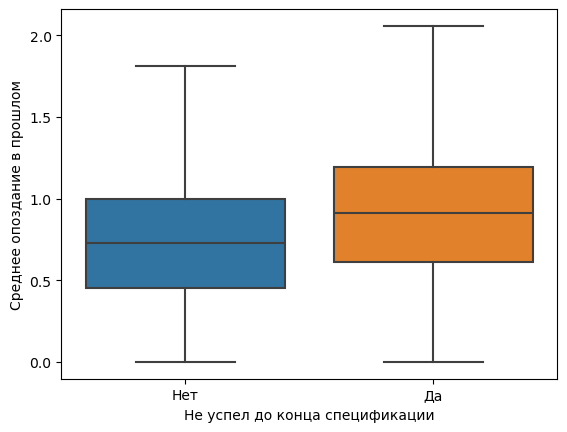

In [17]:
sns.boxplot(x=spec['is_late'], y=spec['supplier_lateness'], showfliers=False).set(xlabel='Не успел до конца спецификации', ylabel='Среднее опоздание в прошлом')
plt.xticks(range(2), ['Нет', 'Да'])
plt.savefig('../figures/supplier_lateness.jpg', bbox_inches='tight')

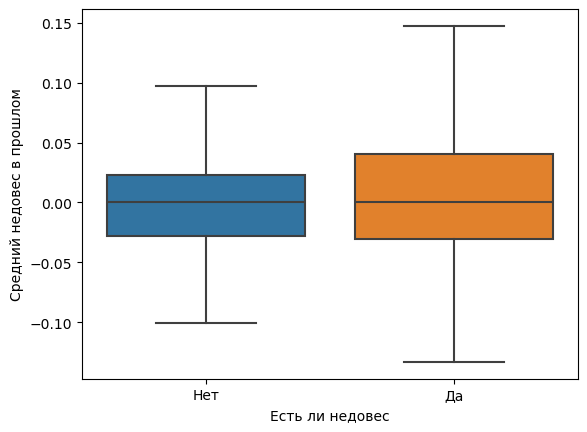

In [18]:
sns.boxplot(x=spec['is_underweight'], y=spec['supplier_underweight'], showfliers=False).set(xlabel='Есть ли недовес', ylabel='Средний недовес в прошлом')
plt.xticks(range(2), ['Нет', 'Да'])
plt.savefig('../figures/supplier_underweight.jpg', bbox_inches='tight')

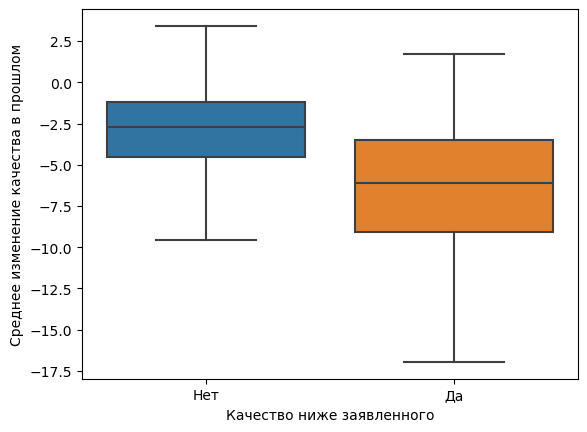

In [19]:
sns.boxplot(x=spec['is_poorquality'], y=spec['supplier_price_change'], showfliers=False).set(xlabel='Качество ниже заявленного', ylabel='Среднее изменение качества в прошлом')
plt.xticks(range(2), ['Нет', 'Да'])
plt.savefig('../figures/supplier_price_change.jpg', bbox_inches='tight')

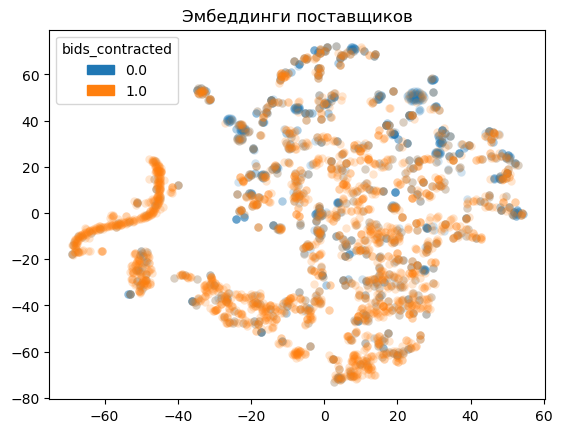

In [24]:
plt.title('Эмбеддинги поставщиков')
temp_spec = spec[~spec['0'].isna()]
show_embeddings(temp_spec[features[1]], temp_spec['bids_contracted'])
plt.savefig('../figures/supplier_embed_contracted.jpg', bbox_inches='tight')

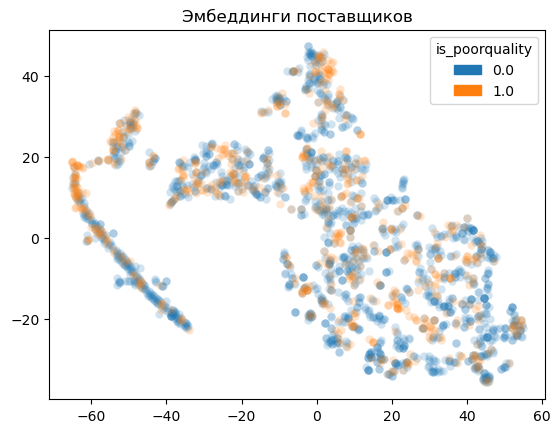

In [25]:
plt.title('Эмбеддинги поставщиков')
temp_spec = spec[~spec['0'].isna() & ~spec['is_poorquality'].isna()]
show_embeddings(temp_spec[features[1]], temp_spec['is_poorquality'])
plt.savefig('../figures/supplier_embed_poorquality.jpg', bbox_inches='tight')

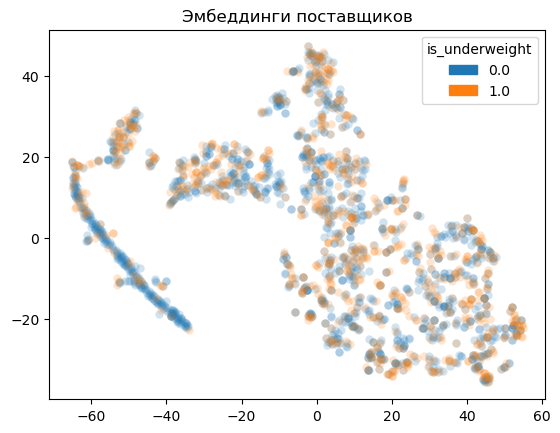

In [26]:
plt.title('Эмбеддинги поставщиков')
temp_spec = spec[~spec['0'].isna() & ~spec['is_underweight'].isna()]
show_embeddings(temp_spec[features[1]], temp_spec['is_underweight'])
plt.savefig('../figures/supplier_embed_underweight.jpg', bbox_inches='tight')

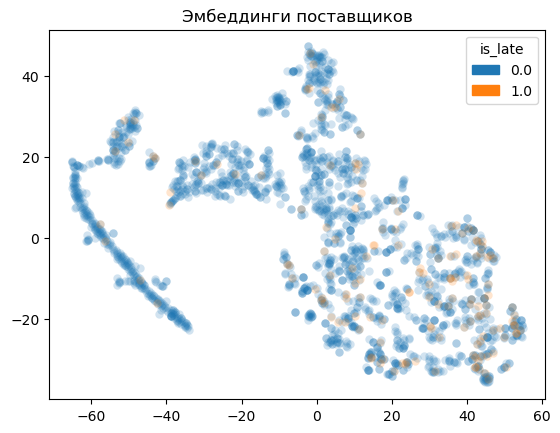

In [27]:
plt.title('Эмбеддинги поставщиков')
temp_spec = spec[~spec['0'].isna() & ~spec['is_late'].isna()]
show_embeddings(temp_spec[features[1]], temp_spec['is_late'])
plt.savefig('../figures/supplier_embed_late.jpg', bbox_inches='tight')

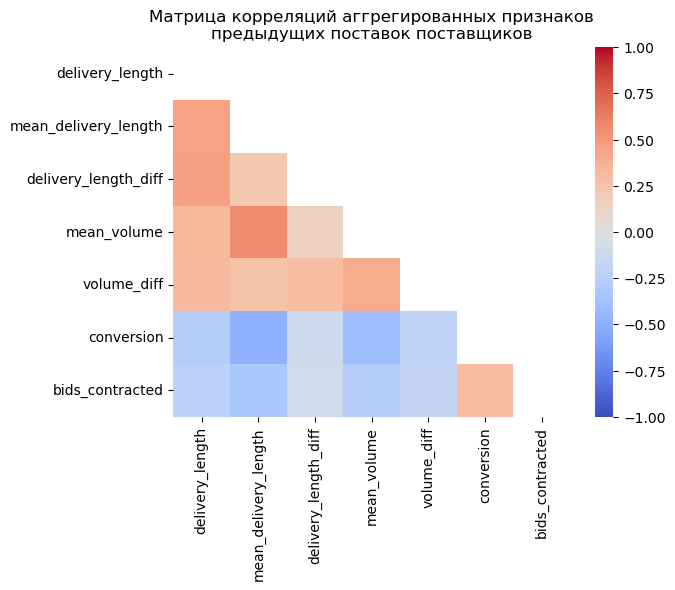

In [28]:
cols = features[2] + ['bids_contracted']
shape_plot = len(cols)
mask = np.zeros((shape_plot, shape_plot))
mask[np.triu_indices_from(mask)] = True

sns.heatmap(spec[cols].corr(), cmap = 'coolwarm', annot = False, 
            mask=mask, vmin=-1, vmax=1).set(
    title='Матрица корреляций аггрегированных признаков\nпредыдущих поставок поставщиков'
            )

plt.savefig('../figures/correlation_matrix.jpg', bbox_inches='tight')

In [9]:
# возьмём эмбеддинг спецификаций отдельно

embed_df = pd.read_csv('../data/processed_data/embed_df2.csv')
embed_df = pd.merge(
    embed_df, spec[['id', 'is_late', 'is_underweight', 'is_poorquality', 'n_deliveries', ]],
    how='left', on=['id', 'id'])

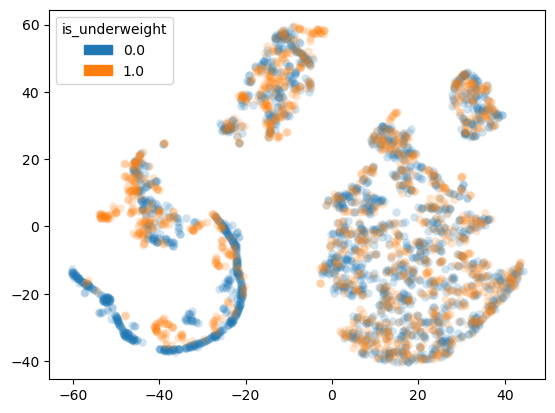

In [10]:
show_embeddings(embed_df[features[1]], embed_df['is_underweight'])

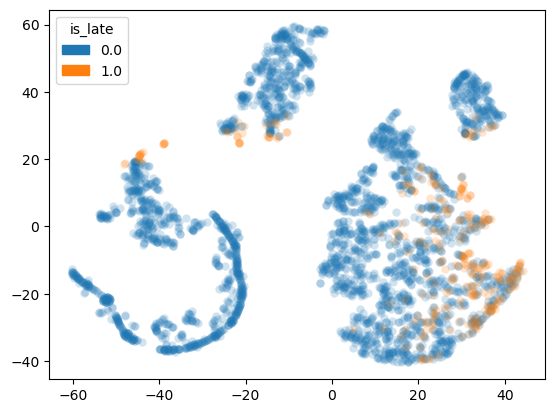

In [11]:
show_embeddings(embed_df[features[1]], embed_df['is_late'])

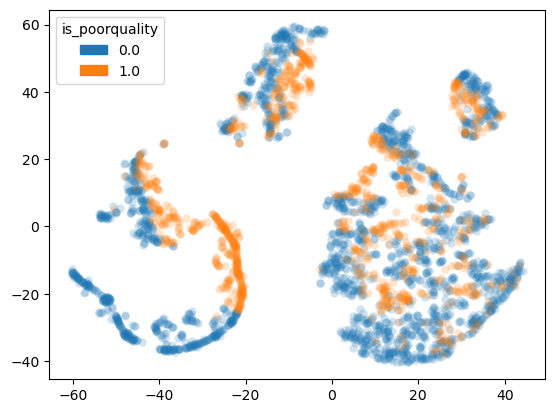

In [12]:
show_embeddings(embed_df[features[1]], embed_df['is_poorquality'])

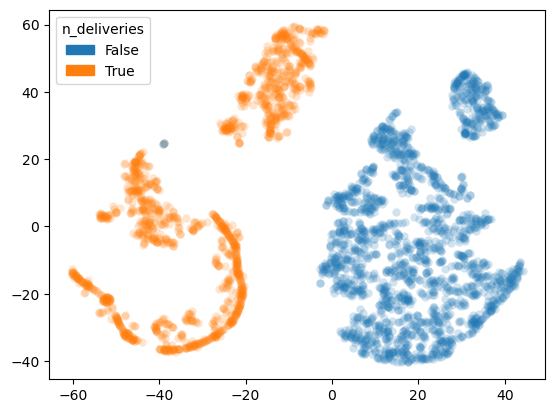

In [13]:
show_embeddings(embed_df[features[1]], embed_df['n_deliveries'] <= 2)